In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.style.use("seaborn-pastel")
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('movies.csv')
df.head()

,Unnamed: 0,TCONST,ORIGINAL_TITLE,TYPE,AVG_RATING,VOTE_COUNT,POPULARITY,GENRES,OVERVIEW,DIRECTORS,IS_ADULT,YEAR,TIME_MINUTES,POSTER_PATH
0,0,tt0000001,Carmencita,short,5.700,2063,1.273,"Documentary,Short",The first woman to appear in front of an Ediso...,William K.L. Dickson,0,1894,1,/6QJowxF4f2hrUtmrDXOqbRDMdDH.jpg
1,1,tt0000005,Blacksmith Scene,short,6.200,2799,1.062,"Comedy,Short",Three men hammer on an anvil and pass a bottle...,William K.L. Dickson,0,1893,1,/6nh4gdZ4cWQbnXDicWIGsOZiZsx.jpg
2,2,tt0000006,Chinese Opium Den,short,5.100,190,NaN,Short,NaN,William K.L. Dickson,0,1894,1,NaN
3,3,tt0000008,Edison Kinetoscopic Record of a Sneeze,short,5.400,2212,0.312,"Documentary,Short",A man (Thomas Edison's assistant) takes a pinc...,William K.L. Dickson,0,1894,1,/utsYe7NaVdiUhXpBwgln3LTucYs.jpg
4,4,tt0177707,Dickson Experimental Sound Film,short,6.700,2589,0.494,"Music,Short",William K.L. Dickson plays the violin while tw...,William K.L. Dickson,0,1894,1,/tuoxqF0sgVpWbVGMPaokmlBwDxw.jpg


In [3]:
df=df[df['IS_ADULT']!=1]

In [4]:
df=df.drop(columns=['Unnamed: 0', 'POPULARITY', 'POSTER_PATH', 'IS_ADULT'])

In [5]:
df.describe([0, 0.05, 0.50, 0.75, 0.85, 0.90, 0.95, 0.99, 1]).T

,count,mean,std,min,0%,5%,50%,75%,85%,90%,95%,99%,100%,max
AVG_RATING,250079.000,7.118,0.957,5.100,5.100,5.400,7.200,7.800,8.100,8.300,8.600,9.200,10.000,10.000
VOTE_COUNT,250079.000,4620.844,38757.658,101.000,101.000,111.000,357.000,1073.000,2225.000,3701.000,8693.000,88821.740,2919274.000,2919274.000


In [6]:
df[df['VOTE_COUNT'] > 10000].count()

TCONST            11388
ORIGINAL_TITLE    11388
TYPE              11388
AVG_RATING        11388
VOTE_COUNT        11388
GENRES            11388
OVERVIEW           7999
DIRECTORS         11388
YEAR              11388
TIME_MINUTES      11388
dtype: int64

In [7]:
df = df[(df['VOTE_COUNT'] > 5000) & (df['TYPE'] == 'movie')]

In [8]:
df.head()

,TCONST,ORIGINAL_TITLE,TYPE,AVG_RATING,VOTE_COUNT,GENRES,OVERVIEW,DIRECTORS,YEAR,TIME_MINUTES
492,tt0004972,The Birth of a Nation,movie,6.100,26531,"Drama,History,War",The Birth of A Nation is a silent film from 19...,D.W. Griffith,1915,195
493,tt0006864,Intolerance: Love's Struggle Throughout the Ages,movie,7.700,16868,"Drama,History","The story of a poor young woman, separated by ...",D.W. Griffith,1916,163
497,tt0009968,Broken Blossoms or The Yellow Man and the Girl,movie,7.200,11140,"Drama,Romance",Broken Blossoms is an American silent film fro...,D.W. Griffith,1919,90
505,tt0011841,Way Down East,movie,7.300,5937,"Drama,Romance",A naive country girl is tricked into a sham ma...,D.W. Griffith,1920,145
507,tt0012532,Orphans of the Storm,movie,7.300,5509,"Drama,History,Romance","Henriette and Louise, a foundling, are raised ...",D.W. Griffith,1921,150


In [9]:
def check_detail(dataframe):
    d = {'SHAPE': dataframe.shape,
        'COLUMNS': dataframe.columns,
        'INDEX': dataframe.index,
        'VALUE TYPES': dataframe.dtypes,
        'DUPLICATED VALUES': dataframe.duplicated().sum(),
        'NUMBER OF UNIQUE VALUES': dataframe.nunique(),
        'ANY MISSING VALUES': dataframe.isnull().values.any(),
        'MISSING VALUES': dataframe.isnull().sum(),
        'DESCRIBE.T': dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T}
    hashtags = '---------------------------'
    for key, val in d.items():
        print(f'{hashtags} {key} {hashtags}')
        print(val)
    print(f'{hashtags} {"LIST END"} {hashtags}')
   

check_detail(dataframe=df)

--------------------------- SHAPE ---------------------------
(14407, 10)
--------------------------- COLUMNS ---------------------------
Index(['TCONST', 'ORIGINAL_TITLE', 'TYPE', 'AVG_RATING', 'VOTE_COUNT', 'GENRES', 'OVERVIEW', 'DIRECTORS', 'YEAR', 'TIME_MINUTES'], dtype='object')
--------------------------- INDEX ---------------------------
Int64Index([   492,    493,    497,    505,    507,    617,    618,    622,    623,    625,
            ...
            251510, 251531, 251592, 251646, 251684, 251872, 251920, 251932, 251955, 251982], dtype='int64', length=14407)
--------------------------- VALUE TYPES ---------------------------
TCONST             object
ORIGINAL_TITLE     object
TYPE               object
AVG_RATING        float64
VOTE_COUNT          int64
GENRES             object
OVERVIEW           object
DIRECTORS          object
YEAR               object
TIME_MINUTES       object
dtype: object
--------------------------- DUPLICATED VALUES ---------------------------
11
----

In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']  # Categorical columns
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtype != 'O']  # Numeric but categorical
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and dataframe[col].dtype == 'O']  # Categorical but cardinal
    cat_cols += num_but_cat  # Combine categorical columns
    cat_cols = [col for col in cat_cols if col not in cat_but_car]  # Exclude cardinal columns from categorical columns

    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != 'O']  # Numerical columns
    num_cols = [col for col in num_cols if col not in num_but_cat]  # Exclude numeric-looking categories

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car
def identify_check(dataframe):
    print('-' * 80)
    print(f'Categorical : {cat_cols}')
    print('-' * 80)
    print(f'Numerical : {num_cols}')
    print('-' * 80)
    print(f'Categorical but Cardinal : {cat_but_car}')

cat_cols, num_cols, cat_but_car = grab_col_names(df)
identify_check(df)

Observations: 14407
Variables: 10
cat_cols: 1
num_cols: 2
cat_but_car: 7
num_but_cat: 0
--------------------------------------------------------------------------------
Categorical : ['TYPE']
--------------------------------------------------------------------------------
Numerical : ['AVG_RATING', 'VOTE_COUNT']
--------------------------------------------------------------------------------
Categorical but Cardinal : ['TCONST', 'ORIGINAL_TITLE', 'GENRES', 'OVERVIEW', 'DIRECTORS', 'YEAR', 'TIME_MINUTES']


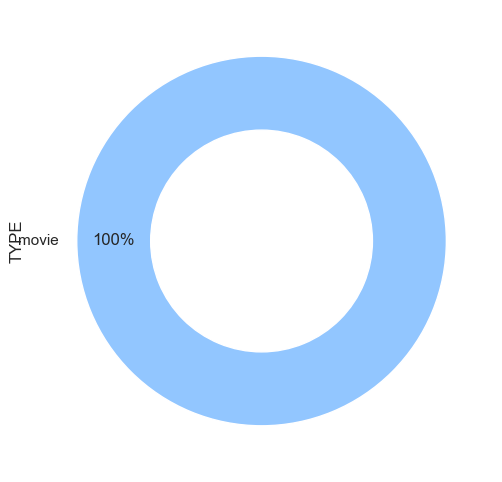

In [11]:
df.TYPE.value_counts().plot.pie(autopct="%.0f%%",figsize=(6,6),pctdistance=0.8,
                                                 wedgeprops=dict(width=0.4))
plt.show()

In [12]:
df.replace('\\N', np.nan, inplace=True)

In [13]:
df.isnull().sum()

TCONST               0
ORIGINAL_TITLE       0
TYPE                 0
AVG_RATING           0
VOTE_COUNT           0
GENRES               0
OVERVIEW          3315
DIRECTORS            0
YEAR                 0
TIME_MINUTES         0
dtype: int64

In [14]:
df = df[df['OVERVIEW'].notna()]

In [15]:
df.head(5)

,TCONST,ORIGINAL_TITLE,TYPE,AVG_RATING,VOTE_COUNT,GENRES,OVERVIEW,DIRECTORS,YEAR,TIME_MINUTES
492,tt0004972,The Birth of a Nation,movie,6.100,26531,"Drama,History,War",The Birth of A Nation is a silent film from 19...,D.W. Griffith,1915,195
493,tt0006864,Intolerance: Love's Struggle Throughout the Ages,movie,7.700,16868,"Drama,History","The story of a poor young woman, separated by ...",D.W. Griffith,1916,163
497,tt0009968,Broken Blossoms or The Yellow Man and the Girl,movie,7.200,11140,"Drama,Romance",Broken Blossoms is an American silent film fro...,D.W. Griffith,1919,90
505,tt0011841,Way Down East,movie,7.300,5937,"Drama,Romance",A naive country girl is tricked into a sham ma...,D.W. Griffith,1920,145
507,tt0012532,Orphans of the Storm,movie,7.300,5509,"Drama,History,Romance","Henriette and Louise, a foundling, are raised ...",D.W. Griffith,1921,150


In [16]:
df.isnull().sum()

TCONST            0
ORIGINAL_TITLE    0
TYPE              0
AVG_RATING        0
VOTE_COUNT        0
GENRES            0
OVERVIEW          0
DIRECTORS         0
YEAR              0
TIME_MINUTES      0
dtype: int64

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
df["OVERVIEW"].head()

492    The Birth of A Nation is a silent film from 19...
493    The story of a poor young woman, separated by ...
497    Broken Blossoms is an American silent film fro...
505    A naive country girl is tricked into a sham ma...
507    Henriette and Louise, a foundling, are raised ...
Name: OVERVIEW, dtype: object

In [19]:
tfidf = TfidfVectorizer(stop_words='english')

In [20]:
tfidf_matrix = tfidf.fit_transform(df['OVERVIEW'])

In [21]:
tfidf_matrix.shape

(11092, 33407)

In [22]:
tfidf.get_feature_names()

['00',
 '000',
 '007',
 '05pm',
 '07',
 '07am',
 '10',
 '100',
 '1000',
 '100th',
 '101',
 '101st',
 '103',
 '108',
 '10b',
 '10crores',
 '10th',
 '11',
 '111',
 '1138',
 '114',
 '117',
 '118',
 '1183',
 '119',
 '11th',
 '12',
 '120',
 '1200',
 '1206',
 '1215',
 '1250',
 '125th',
 '12th',
 '13',
 '1300',
 '133',
 '1344',
 '13b',
 '13th',
 '14',
 '140',
 '1400',
 '1408',
 '1413',
 '142',
 '1429',
 '144',
 '145',
 '1475',
 '148',
 '1492',
 '14pm',
 '14th',
 '15',
 '150',
 '150000',
 '150th',
 '1536',
 '155',
 '1564',
 '1572',
 '1592',
 '1593',
 '1595',
 '1597',
 '1598',
 '1599',
 '15th',
 '15yrs',
 '16',
 '160',
 '1600',
 '1600s',
 '1601',
 '161',
 '1610',
 '1630s',
 '164',
 '165',
 '1671',
 '168',
 '1681',
 '1691',
 '1692',
 '16th',
 '17',
 '170',
 '1700',
 '1700s',
 '174',
 '1740',
 '1760',
 '1776',
 '1793',
 '1797',
 '17th',
 '18',
 '180',
 '1800',
 '1804',
 '180km',
 '1812',
 '1816',
 '1818',
 '1820',
 '1820s',
 '1824',
 '1825',
 '1830',
 '1830s',
 '1831',
 '1836',
 '1839',
 '1840s',

In [23]:
tfidf_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
cosine_sim = cosine_similarity(tfidf_matrix,
                               tfidf_matrix)

In [25]:
cosine_sim.shape

(11092, 11092)

In [26]:
cosine_sim[1]

array([0.03287762, 1.        , 0.04177081, ..., 0.        , 0.        ,
       0.        ])

In [27]:
indices = pd.Series(df.index, index=df['ORIGINAL_TITLE'])

In [28]:
indices = indices[~indices.index.duplicated(keep='last')]

In [29]:
movie_index = indices['Way Down East']

In [30]:
cosine_sim[movie_index]

array([0.        , 0.        , 0.05705682, ..., 0.        , 0.        ,
       0.        ])

In [31]:
similarity_scores = pd.DataFrame(cosine_sim[movie_index],
                                 columns=["score"])

In [32]:
movie_indices = similarity_scores.sort_values("score", ascending=False)[1:11].index

In [33]:
df['ORIGINAL_TITLE'].iloc[movie_indices]

79588                           The Swan Princess
1796                Sunrise: A Song of Two Humans
6380                                    The Mummy
61195                        Beauty and the Beast
76898                       It's a Boy Girl Thing
74387                            My Cousin Rachel
46074                        Hauru no ugoku shiro
108930    O Ano em Que Meus Pais Saíram de Férias
106631                             Starter for 10
105187                             Under the Skin
Name: ORIGINAL_TITLE, dtype: object

In [34]:
def content_based_recommender(title, cosine_sim, dataframe):
    # index'leri olusturma
    indices = pd.Series(dataframe.index, index=dataframe['ORIGINAL_TITLE'])
    indices = indices[~indices.index.duplicated(keep='last')]
    # title'ın index'ini yakalama
    movie_index = indices[title]
    # title'a gore benzerlik skorlarını hesapalama
    similarity_scores = pd.DataFrame(cosine_sim[movie_index], columns=["score"])
    # kendisi haric ilk 10 filmi getirme
    movie_indices = similarity_scores.sort_values("score", ascending=False)[1:11].index
    return dataframe['ORIGINAL_TITLE'].iloc[movie_indices]

In [35]:
content_based_recommender('Way Down East', cosine_sim, df)

79588                           The Swan Princess
1796                Sunrise: A Song of Two Humans
6380                                    The Mummy
61195                        Beauty and the Beast
76898                       It's a Boy Girl Thing
74387                            My Cousin Rachel
46074                        Hauru no ugoku shiro
108930    O Ano em Que Meus Pais Saíram de Férias
106631                             Starter for 10
105187                             Under the Skin
Name: ORIGINAL_TITLE, dtype: object

In [36]:
content_based_recommender('Orphans of the Storm', cosine_sim, df)

244571    El cadáver de Anna Fritz
89541                          Ida
71889            Anna and the King
96456                    Leap Year
16469        The Bridge at Remagen
88316                Freaky Friday
11200                      Victory
117812                  Deathwatch
80552                The Big Green
76576                       Heaven
Name: ORIGINAL_TITLE, dtype: object